# Weekday and weekend split

In [243]:
library(lubridate)  #work with dates
library(xts)
library(forecast)
lct <- Sys.getlocale("LC_TIME"); Sys.setlocale("LC_TIME", "C") #needed for as.POSIXct

[1] "C"

In [244]:
data <- read.csv('bicup2006.csv',sep=',')
head(data)
dim(data)

DATE,TIME,DEMAND
1-Mar-05,6:30,1
1-Mar-05,6:45,2
1-Mar-05,7:00,4
1-Mar-05,7:15,0
1-Mar-05,7:30,10
1-Mar-05,7:45,13


[1] 1512    3

In [245]:
daytype<-rep("weekday",1512)
daytype[253:378]<-"weekend"
daytype[694:819]<-"weekend"
daytype[1135:1260]<-"weekend"
dtype<-rep(1,1512)
dtype[which(daytype=="weekend")]<-3


myseason<-rep(seq(1,63),24)

date.and.time<-paste(data$DATE,data$TIME) #combine date and time in one column
posix.date<-as.POSIXct(date.and.time,format="%d-%b-%y %H:%M")
#create new dataframe with columns posix.date and demand
newdata<-data.frame(posix.date,data$DEMAND,daytype,myseason,dtype)
names(newdata)<-c('date.and.time','demand','daytype','myseason','dtype')
head(newdata)
dim(newdata)

date.and.time,demand,daytype,myseason,dtype
2005-03-01 06:30:00,1,weekday,1,1
2005-03-01 06:45:00,2,weekday,2,1
2005-03-01 07:00:00,4,weekday,3,1
2005-03-01 07:15:00,0,weekday,4,1
2005-03-01 07:30:00,10,weekday,5,1
2005-03-01 07:45:00,13,weekday,6,1


[1] 1512    5

In [246]:
weekend.data<-newdata[newdata$daytype=='weekend',]
weekday.data<-newdata[newdata$daytype=='weekday',]

## Weekday split

In [247]:
#indexes for first two weeks
training.weekday<-weekday.data[1:(10*63),]
#indexes for last week
validation.weekday<-weekday.data[((10*63)+1):(15*63),]
#indexes for last 3 days
future.weekday<-weekday.data[((15*63)+1):dim(weekday.data)[1],]

## Weekend split

In [248]:
#indexes for first two weeks
training.weekend<-weekend.data[1:(63*4),]
#indexes for last week
validation.weekend<-weekend.data[((4*63)+1):(6*63),]

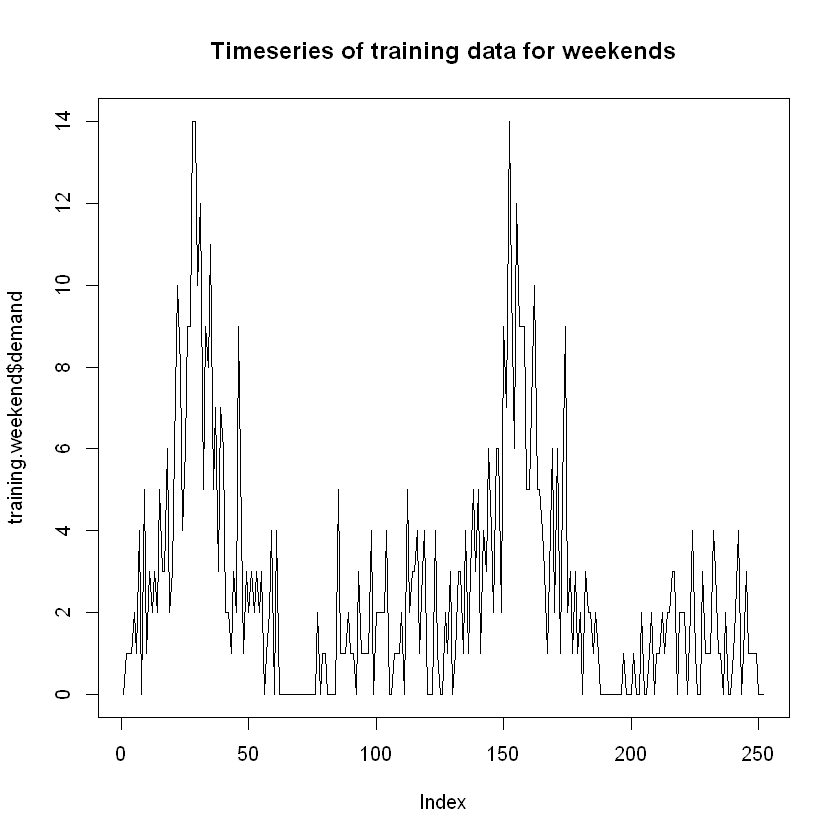

In [250]:
plot(training.weekend$demand,type='l',main="Timeseries of training data for weekends")

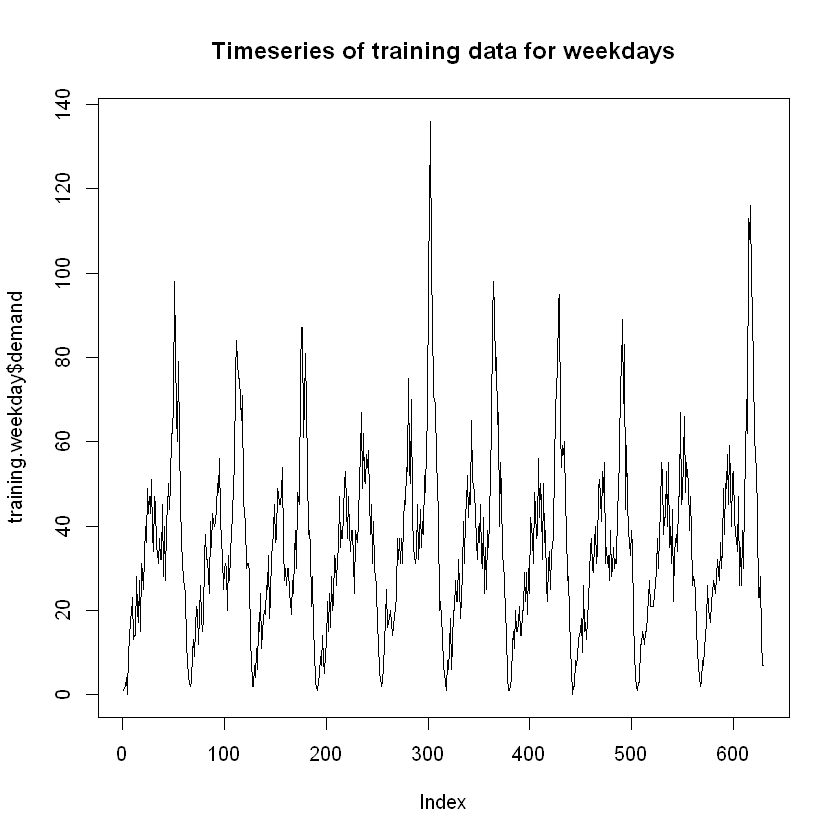

In [251]:
plot(training.weekday$demand,type='l',main="Timeseries of training data for weekdays")

In [252]:
newdata.xts = xts(coredata(weekday.data$demand), order.by=as.POSIXct(weekday.data$date.and.time))
attr(newdata.xts,"frequency")<-63
periodicity(newdata.xts)
total_timeseries<-as.ts(newdata.xts)

15 minute periodicity from 2005-03-01 06:30:00 to 2005-03-24 22:00:00 

In [253]:
seasonal_data<-data.frame(weekday.data,seasonaldummy(total_timeseries))

# TBATS

## Weekdays

In [254]:
my.xts = xts(coredata(training.weekday$demand), order.by=as.POSIXct(training.weekday$date.and.time))
attr(my.xts,"frequency")<-63
periodicity(my.xts)
timeseries<-as.ts(my.xts)


multiple<-msts(timeseries, seasonal.periods=c(63,5*63))
frequency(multiple)

15 minute periodicity from 2005-03-01 06:30:00 to 2005-03-14 22:00:00 

[1] 315

In [255]:
model<-tbats(multiple,seasonal.periods=c(63,5*63))

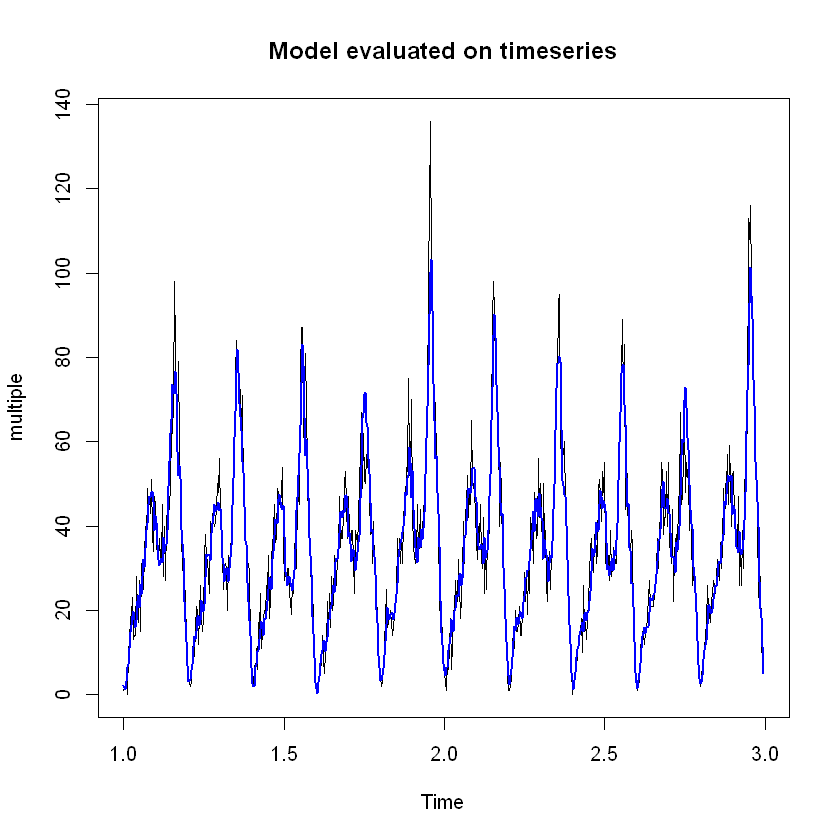

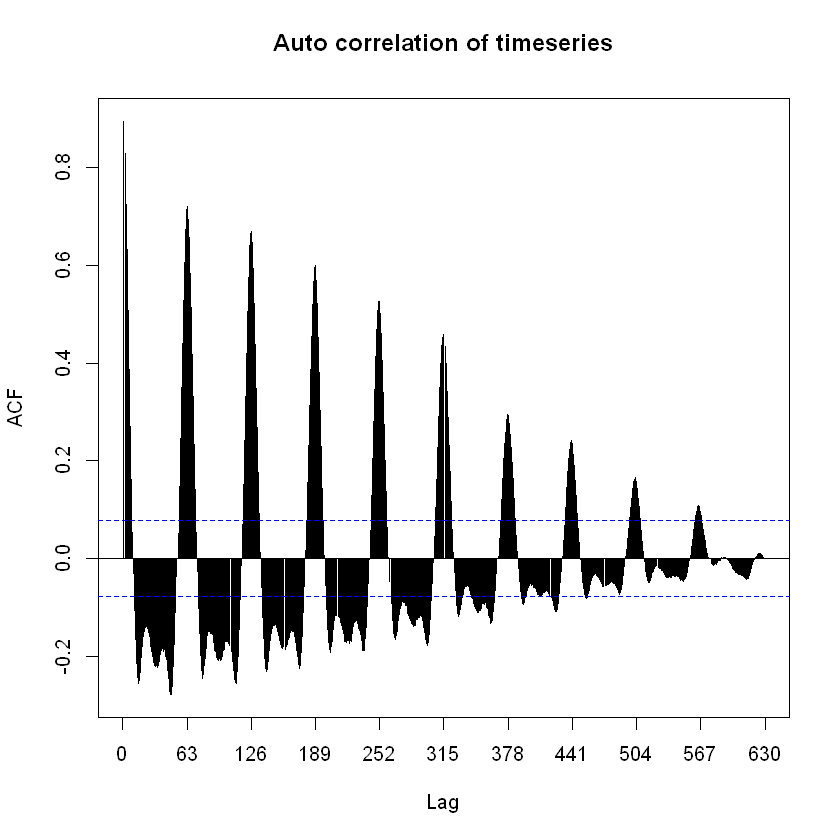

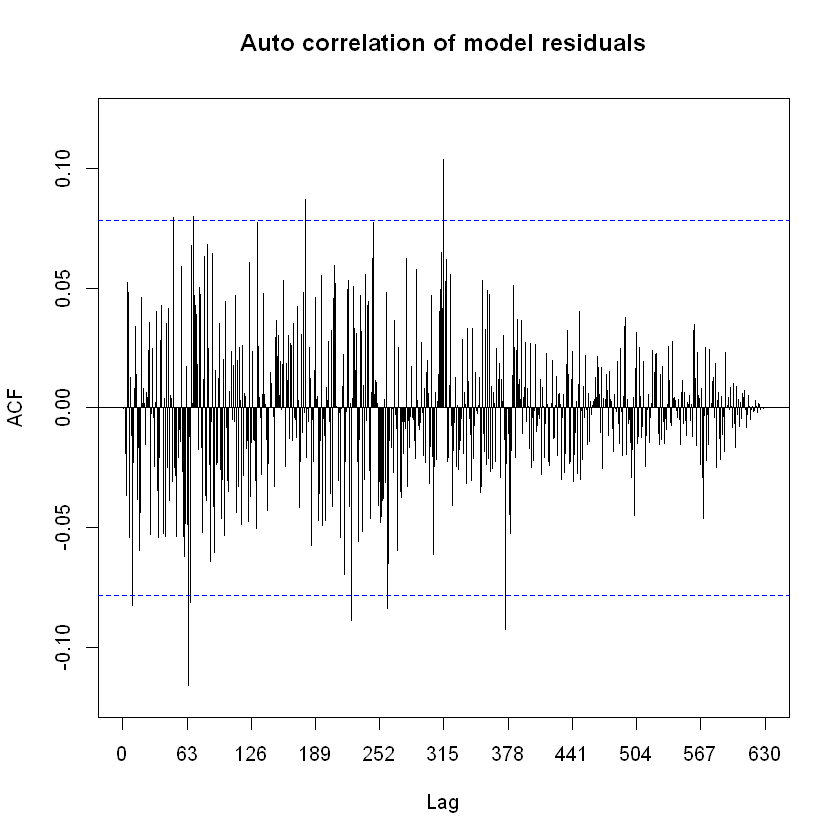

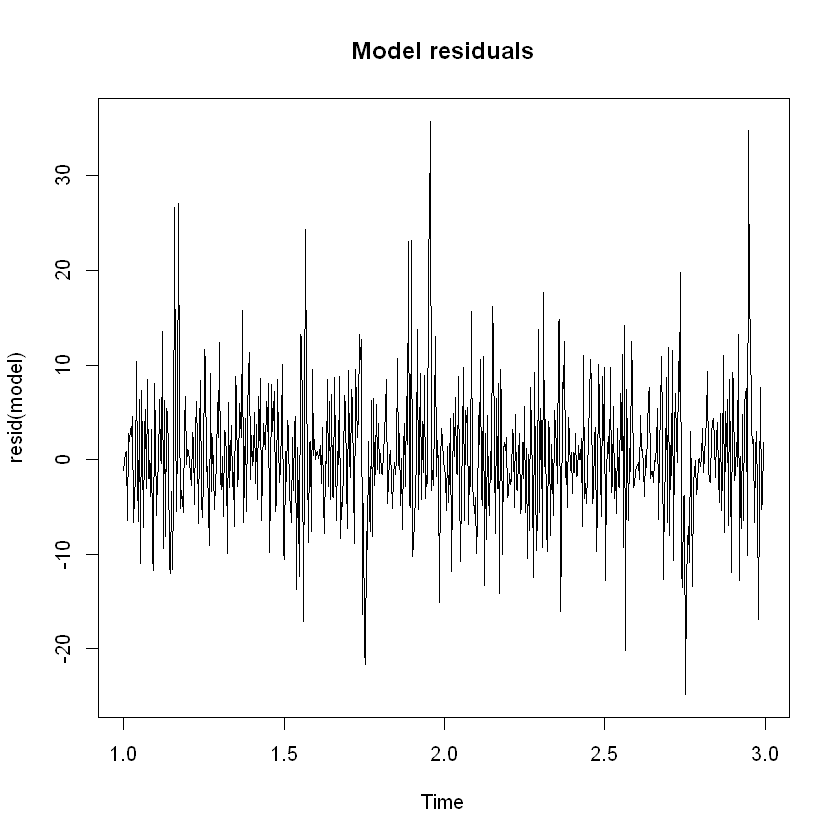

ERROR: Error: $ operator is invalid for atomic vectors


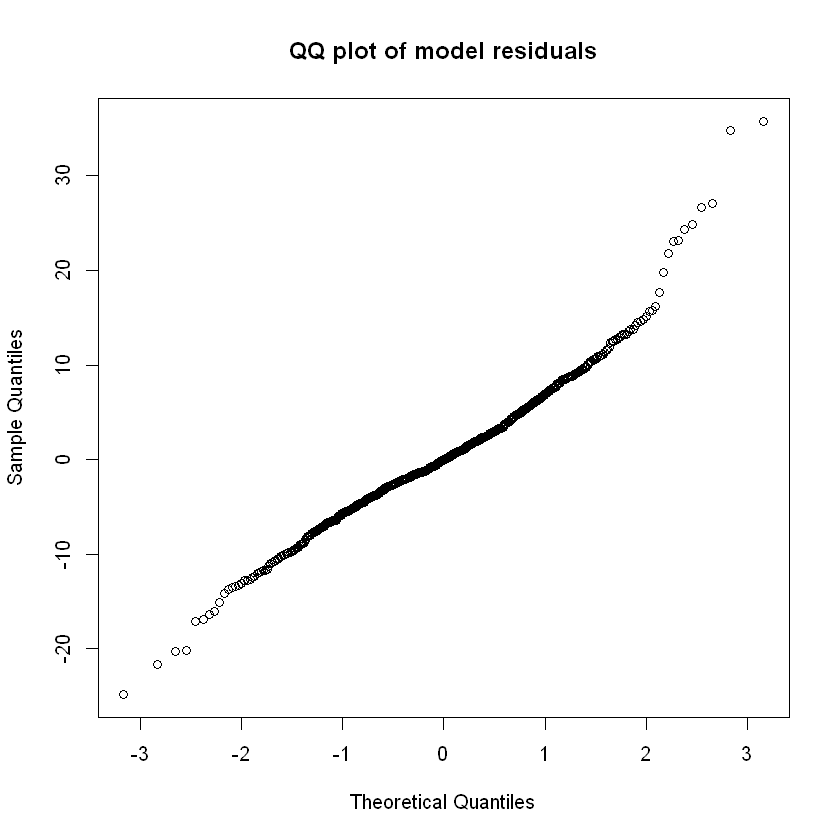

In [256]:
#coefficients(model)
coef<-coefficients(model)
plot(multiple,main='Model evaluated on timeseries')
lines(model$fitted, lwd = 2,col='blue')

#model testing
Acf(multiple,main='Auto correlation of timeseries')
Acf(resid(model),main='Auto correlation of model residuals')
plot(resid(model),main='Model residuals')
qqnorm(resid(model),main='QQ plot of model residuals')
qqline(resid(model))

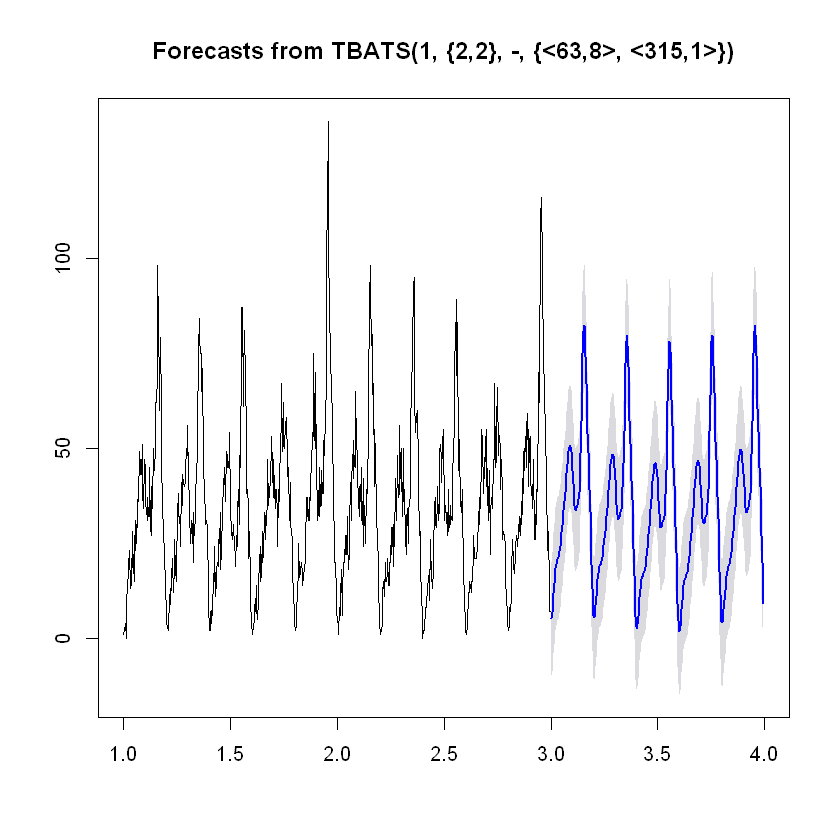

In [257]:
myforecast<-forecast(model,63*5,level = c(95))
plot(myforecast)

In [258]:
residuals<-myforecast$mean-validation.weekday$demand
results<-data.frame(validation.weekday$demand,myforecast$mean,residuals)
head(results)

validation.weekday.demand,myforecast.mean,residuals
0,5.113354,5.113354
2,5.071780,3.071780
4,6.821224,2.821224
7,9.049038,2.049038
13,11.843627,-1.156373
11,14.281549,3.281549


In [259]:
#Adjusted R-Squared
SSE=sum(residuals**2)
SSyy=sum((validation.weekday$demand-mean(validation.weekday$demand))**2)
1-(SSE/SSyy)

[1] 0.7405239

## Weekends

In [260]:
my.xts = xts(coredata(training.weekend$demand), order.by=as.POSIXct(training.weekend$date.and.time))
attr(my.xts,"frequency")<-63
periodicity(my.xts)
timeseries<-as.ts(my.xts)


multiple<-msts(timeseries, seasonal.periods=c(63,2*63))
frequency(multiple)

15 minute periodicity from 2005-03-05 06:30:00 to 2005-03-13 22:00:00 

[1] 126

In [261]:
model<-tbats(multiple,seasonal.periods=c(63,2*63))

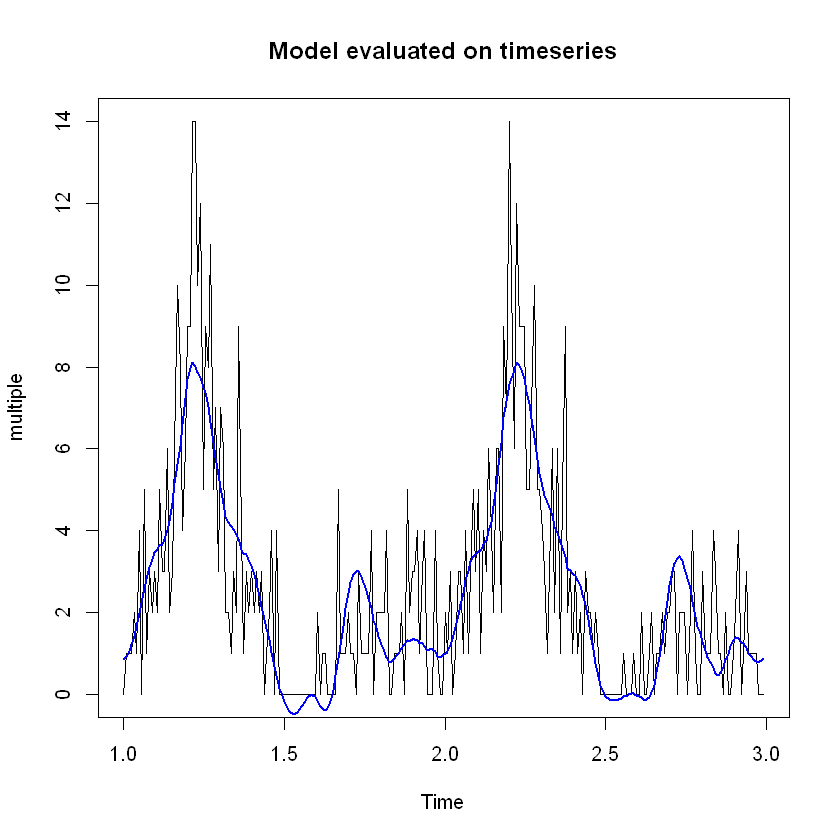

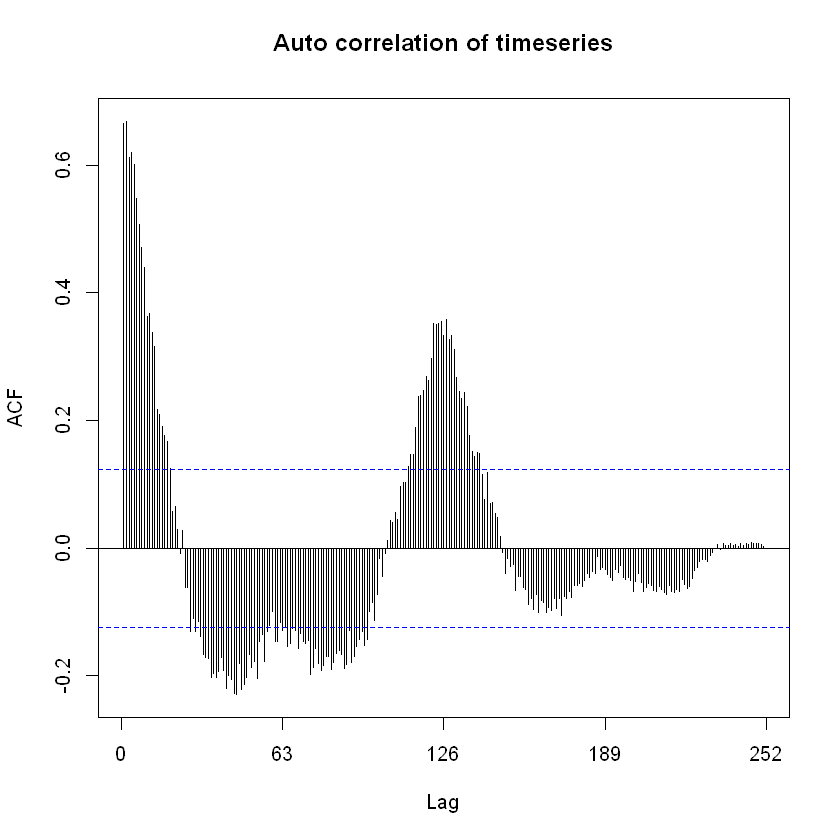

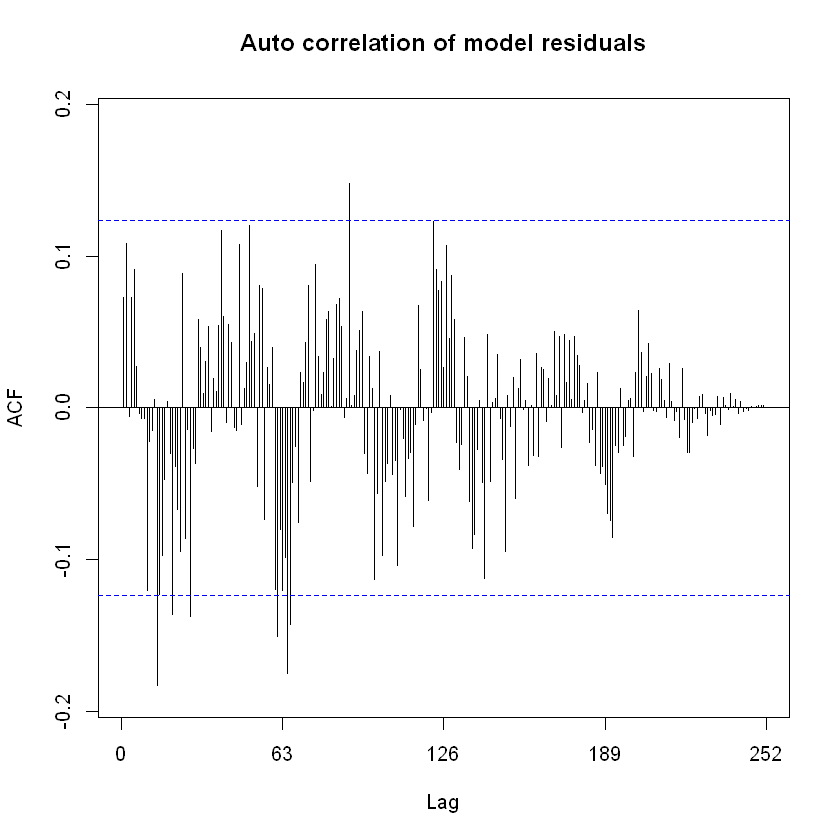

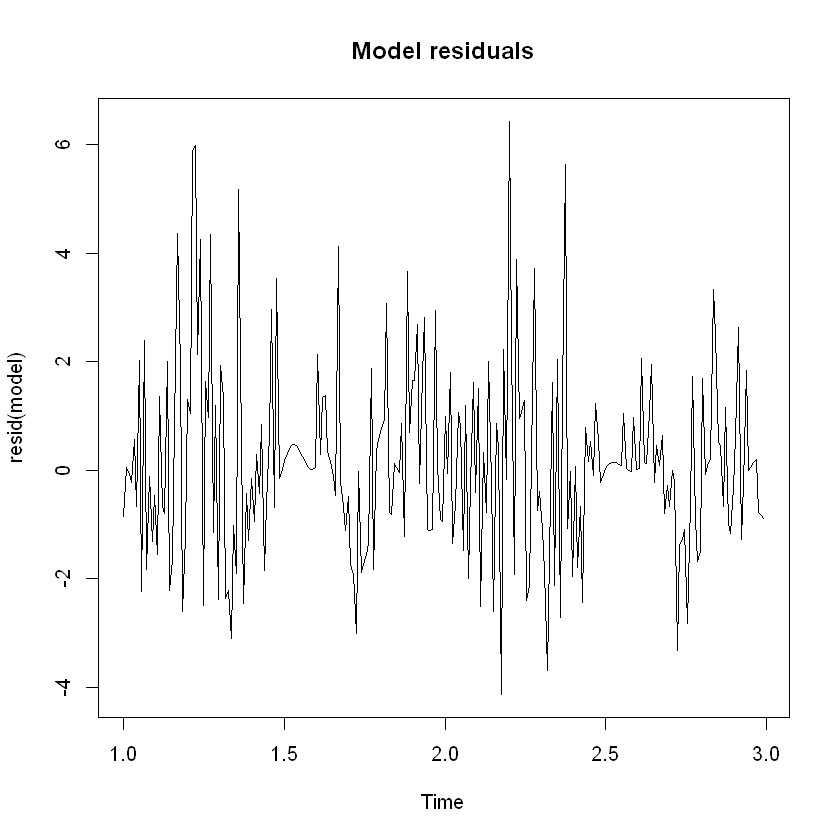

ERROR: Error: $ operator is invalid for atomic vectors


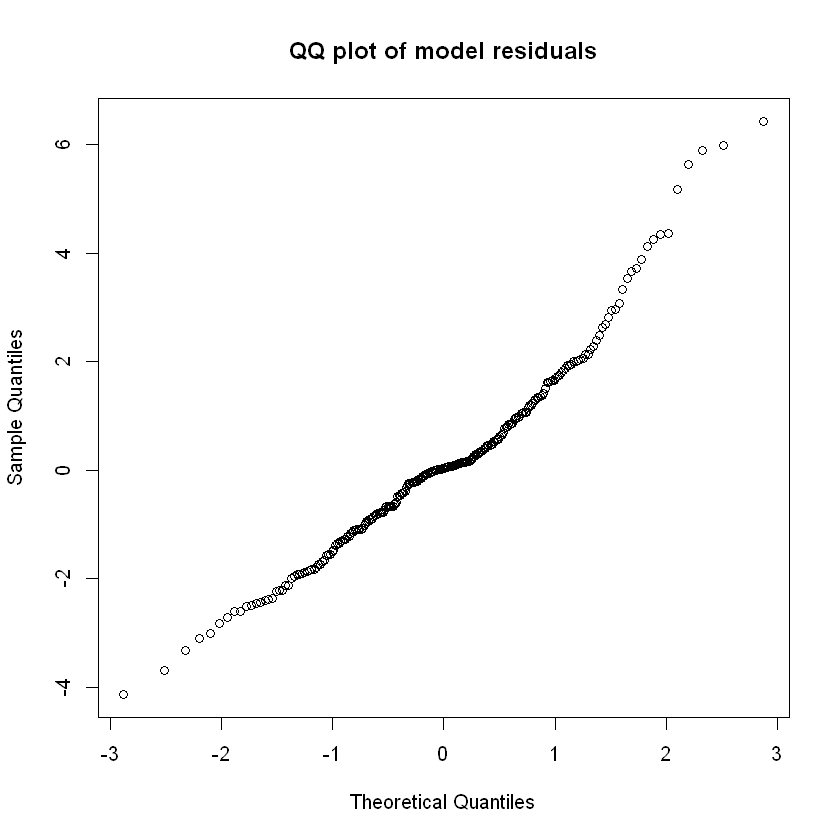

In [262]:
#coefficients(model)
coef<-coefficients(model)
plot(multiple,main='Model evaluated on timeseries')
lines(model$fitted, lwd = 2,col='blue')

#model testing
Acf(multiple,main='Auto correlation of timeseries')
Acf(resid(model),main='Auto correlation of model residuals')
plot(resid(model),main='Model residuals')
qqnorm(resid(model),main='QQ plot of model residuals')
qqline(resid(model))

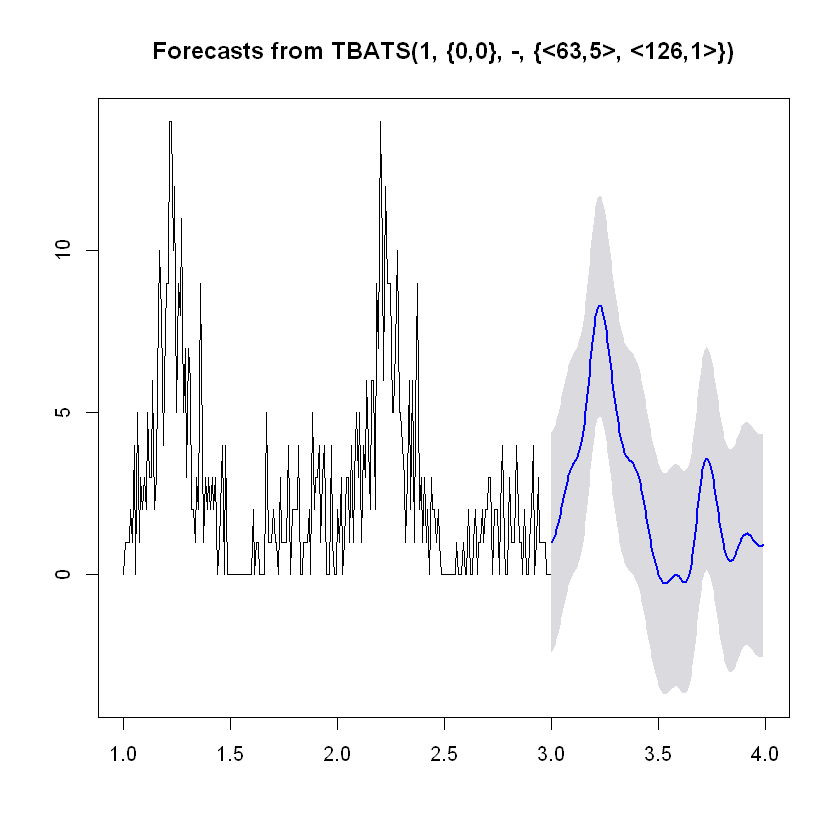

In [263]:
myforecast<-forecast(model,63*2,level = c(95))
plot(myforecast)

In [264]:
residuals.weekend<-myforecast$mean-validation.weekend$demand
results.weekend<-data.frame(validation.weekend$demand,myforecast$mean,residuals.weekend)
head(results.weekend)

validation.weekend.demand,myforecast.mean,residuals.weekend
0,0.9844677,0.9844677
0,1.0812415,1.0812415
1,1.2140253,0.2140253
1,1.3842228,0.3842228
3,1.5904889,-1.4095111
0,1.8276690,1.8276690


In [265]:
#Adjusted R-Squared
SSE=sum(residuals.weekend**2)
SSyy=sum((validation.weekend$demand-mean(validation.weekend$demand))**2)
1-(SSE/SSyy)

[1] 0.619255

# Our model

In [266]:
newdata.xts = xts(coredata(newdata$demand), order.by=as.POSIXct(newdata$date.and.time))
attr(newdata.xts,"frequency")<-63
periodicity(newdata.xts)
total_timeseries<-as.ts(newdata.xts)


seasonal_data<-data.frame(newdata,seasonaldummy(total_timeseries))

15 minute periodicity from 2005-03-01 06:30:00 to 2005-03-24 22:00:00 

## Split weekday and weekend training,validation and future sets

In [267]:
#indexes for first two weeks
training.weekday<-weekday.data[1:(10*63),]
#indexes for last week
validation.weekday<-weekday.data[((10*63)+1):(15*63),]
#indexes for last 3 days
future.weekday<-weekday.data[((15*63)+1):dim(weekday.data)[1],]

my.xts = xts(coredata(training.weekday$demand), order.by=as.POSIXct(training.weekday$date.and.time))
attr(my.xts,"frequency")<-63
periodicity(my.xts)
timeseries.weekday<-as.ts(my.xts)

15 minute periodicity from 2005-03-01 06:30:00 to 2005-03-14 22:00:00 

In [268]:
#indexes for first two weeks
training.weekend<-weekend.data[1:(63*4),]
#indexes for last week
validation.weekend<-weekend.data[((4*63)+1):(6*63),]

my.xts = xts(coredata(training.weekend$demand), order.by=as.POSIXct(training.weekend$date.and.time))
attr(my.xts,"frequency")<-63
periodicity(my.xts)
timeseries.weekend<-as.ts(my.xts)

15 minute periodicity from 2005-03-05 06:30:00 to 2005-03-13 22:00:00 

## Weekend  Model

In [191]:
weekend.data<-seasonal_data[seasonal_data$daytype=='weekend',]

day_column<-rep(1,378)
for(i in seq(1:378)){
    
        day<-strtoi(substr(weekend.data$date.and.time[i],9,10),base = 10)
        if(day==5 | day==12 | day==19 | day==26){
            day_column[i]<-0
        }else if(day==6 | day==13 | day==20){
            day_column[i]<-1
        }
}

In [192]:
model.data.weekend<-data.frame(weekend.data$demand, day_column, weekend.data[6:67], day_column*weekend.data[6:67])

colnames(model.data.weekend)<-c('demand','daynumber',colnames(model.data.weekend)[3:64]
                                , paste(colnames(model.data.weekend)[3:64],'.day',sep = ''))

trainingdata<-model.data.weekend[1:(63*4),]

head(model.data.weekend)
dim(model.data.weekend)
names(model.data.weekend)

,demand,daynumber,S1,S2,S3,S4,S5,S6,S7,S8,...,S53.day,S54.day,S55.day,S56.day,S57.day,S58.day,S59.day,S60.day,S61.day,S62.day
253,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
254,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
255,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
256,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
257,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
258,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


[1] 378 126

[1] "demand"    "daynumber" "S1"        "S2"        "S3"        "S4"       
  [7] "S5"        "S6"        "S7"        "S8"        "S9"        "S10"      
 [13] "S11"       "S12"       "S13"       "S14"       "S15"       "S16"      
 [19] "S17"       "S18"       "S19"       "S20"       "S21"       "S22"      
 [25] "S23"       "S24"       "S25"       "S26"       "S27"       "S28"      
 [31] "S29"       "S30"       "S31"       "S32"       "S33"       "S34"      
 [37] "S35"       "S36"       "S37"       "S38"       "S39"       "S40"      
 [43] "S41"       "S42"       "S43"       "S44"       "S45"       "S46"      
 [49] "S47"       "S48"       "S49"       "S50"       "S51"       "S52"      
 [55] "S53"       "S54"       "S55"       "S56"       "S57"       "S58"      
 [61] "S59"       "S60"       "S61"       "S62"       "S1.day"    "S2.day"   
 [67] "S3.day"    "S4.day"    "S5.day"    "S6.day"    "S7.day"    "S8.day"   
 [73] "S9.day"    "S10.day"   "S11.day"   "S12.day"   "S13.day"   "S14.day"  
 [79] "S15.day"   "S16.day"   "S17.day"   "S18.day"   "S19.day"   "S20.day"  
 [85] "S21.day"   "S22.day"   "S23.day"   "S24.day"   "S25.day"   "S26.day"  
 [91] "S27.day"   "S28.day"   "S29.day"   "S30.day"   "S31.day"   "S32.day"  
 [97] "S33.day"   "S34.day"   "S35.day"   "S36.day"   "S37.day"   "S38.day"  
[103] "S39.day"   "S40.day"   "S41.day"   "S42.day"   "S43.day"   "S44.day"  
[109] "S45.day"   "S46.day"   "S47.day"   "S48.day"   "S49.day"   "S50.day"  
[115] "S51.day"   "S52.day"   "S53.day"   "S54.day"   "S55.day"   "S56.day"  
[121] "S57.day"   "S58.day"   "S59.day"   "S60.day"   "S61.day"   "S62.day"

In [193]:
model<-lm(demand~.,trainingdata)

summary(model)


Call:
lm(formula = demand ~ ., data = trainingdata)

Residuals:
   Min     1Q Median     3Q    Max 
  -4.0   -0.5    0.0    0.5    4.0 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.343e-15  1.198e+00   0.000 1.000000    
daynumber   -5.475e-15  1.694e+00   0.000 1.000000    
S1           1.000e+00  1.694e+00   0.590 0.555994    
S2           1.000e+00  1.694e+00   0.590 0.555994    
S3           2.000e+00  1.694e+00   1.181 0.239923    
S4           5.000e-01  1.694e+00   0.295 0.768335    
S5           1.500e+00  1.694e+00   0.886 0.377537    
S6           2.000e+00  1.694e+00   1.181 0.239923    
S7           3.500e+00  1.694e+00   2.066 0.040846 *  
S8           5.000e-01  1.694e+00   0.295 0.768335    
S9           4.500e+00  1.694e+00   2.657 0.008912 ** 
S10          1.000e+00  1.694e+00   0.590 0.555994    
S11          3.000e+00  1.694e+00   1.771 0.078956 .  
S12          3.500e+00  1.694e+00   2.066 0.040846 *  
S13          3.000e+00 

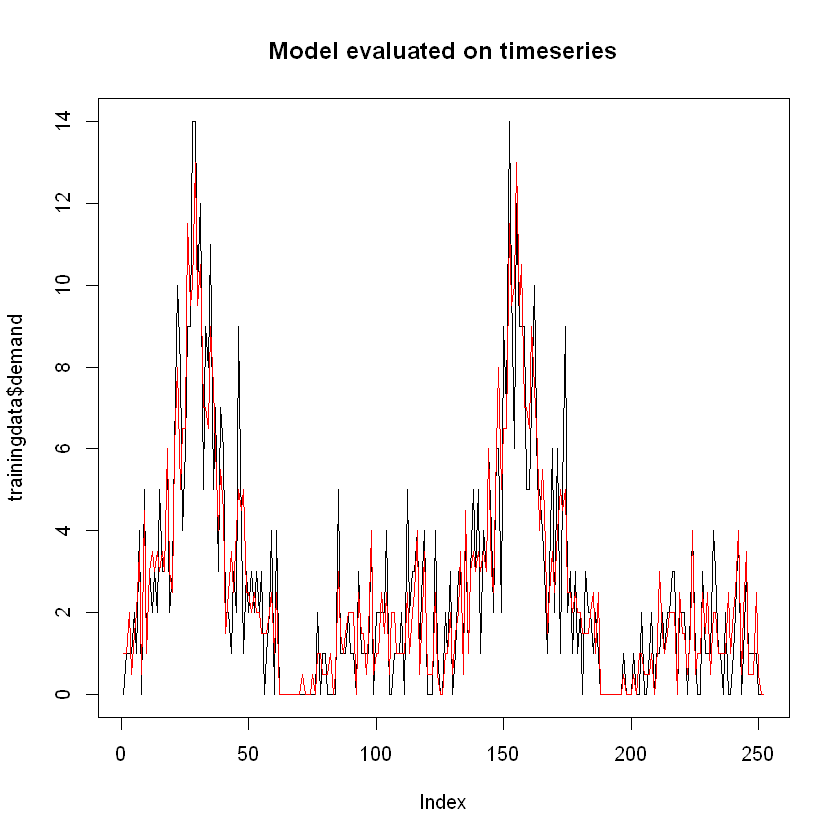

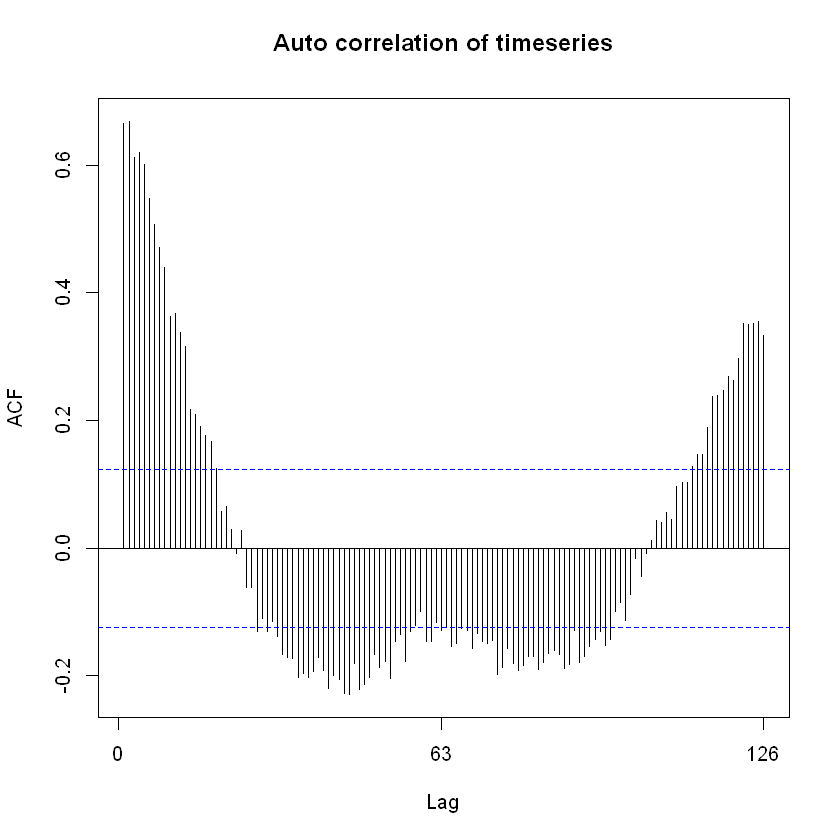

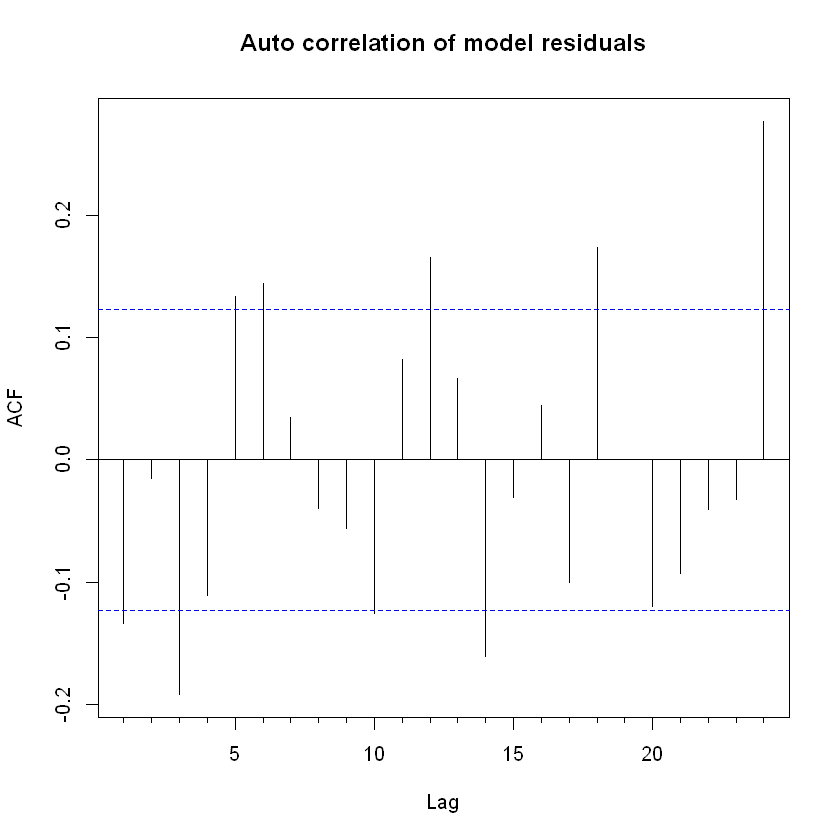

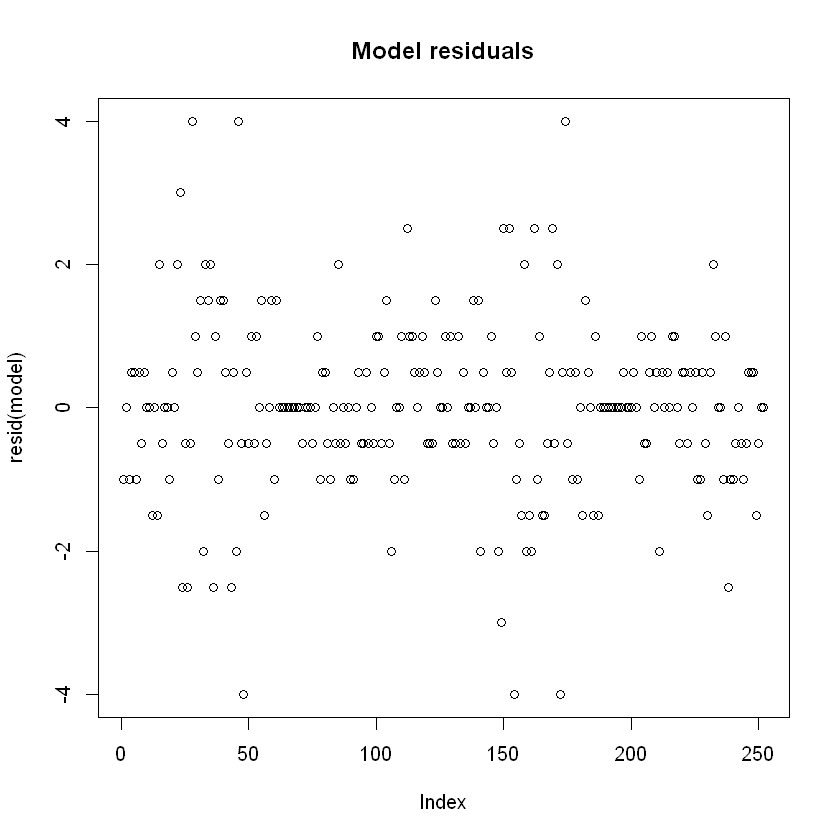

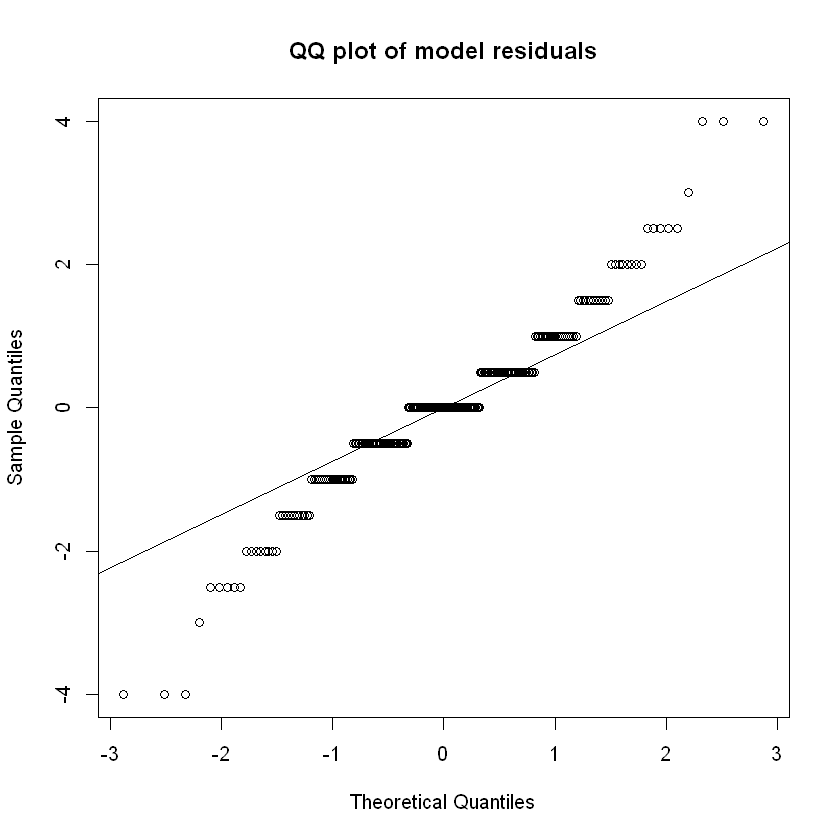

In [194]:
#coefficients(model)
coef<-coefficients(model)
plot(trainingdata$demand,main='Model evaluated on timeseries',type='l')
lines(model$fitted, lwd = 1,col='red')

#model testing
Acf(timeseries.weekend,main='Auto correlation of timeseries')
Acf(resid(model),main='Auto correlation of model residuals')
plot(resid(model),main='Model residuals')
qqnorm(resid(model),main='QQ plot of model residuals')
qqline(resid(model))

### Evaluation and predictions

In [152]:
#We create a new dataframe to make the model calculation easier below
ones<-rep(1,378)
#we remove the demand column since thats what we predict and we replace it with ones
#so they are multiplied by the intercept coefficient
final.model.data<-data.frame(ones,model.data.weekend[,-1])


head(final.model.data)
dim(final.model.data)

,ones,daynumber,S1,S2,S3,S4,S5,S6,S7,S8,...,S53.day,S54.day,S55.day,S56.day,S57.day,S58.day,S59.day,S60.day,S61.day,S62.day
253,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
254,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
255,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
256,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
257,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
258,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


[1] 378 126

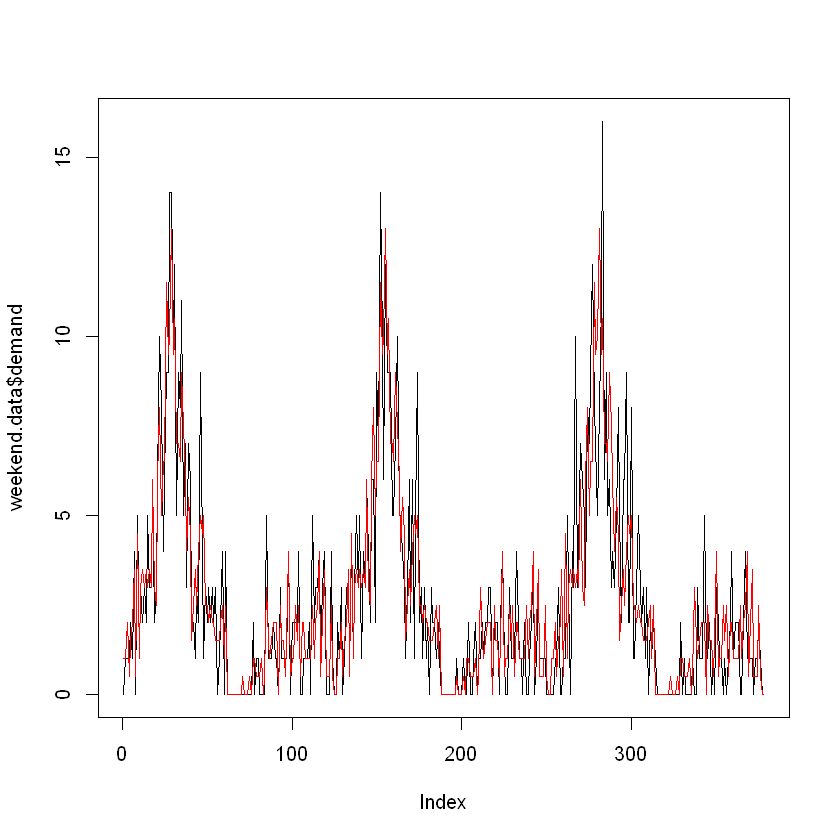

In [153]:
#coefficients(model)
coef<-coefficients(model)

mymodel = rowSums(mapply("*", as.data.frame(final.model.data),coef))

plot(weekend.data$demand,type='l')
lines(mymodel,lwd = 1,col='red')

In [174]:
actual.demand<-validation.weekend$demand
predicted.demand<-mymodel[253:378]

residuals<-actual.demand-predicted.demand

#Adjusted R-Squared #by a crazy coincidence k=n-1 so we use normal R2

n=length(actual.demand)
k=126-1 #Subtract one to ignore intercept

SSE=sum(residuals**2)
SSyy=sum((actual.demand-mean(actual.demand))**2)
1-(SSE/SSyy)


[1] 0.5445352

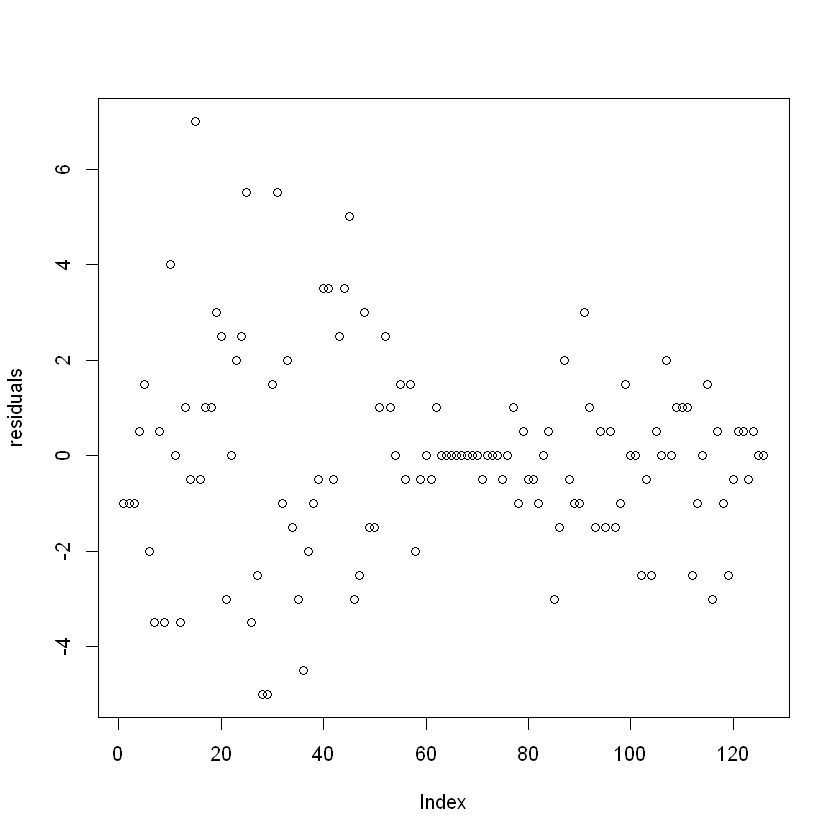

In [175]:
plot(residuals)

In [176]:
#ON TRAIN
actual.demand<-training.weekend$demand
predicted.demand<-mymodel[1:126]

residuals<-actual.demand-predicted.demand

#Adjusted R-Squared
n=length(actual.demand)
k=126-1 #Subtract one to ignore intercept

SSE=sum(residuals**2)
SSyy=sum((actual.demand-mean(actual.demand))**2)
1-(SSE/SSyy)

[1] 0.8335377

## Weekday model

In [274]:
weekday.data<-seasonal_data[seasonal_data$daytype=='weekday' & !is.na(seasonal_data$demand) ,]

day_column<-rep(1,945)
for(i in seq(1:945)){
    
        day<-strtoi(substr(newdata$date.and.time[i],9,10),base = 10)
        if(day==7 | day==14 | day==21){
            day_column[i]<-1
        }else if(day==1 | day==8 | day==15 | day==22){
            day_column[i]<-2
        }else if(day==2 | day==9 | day==16 | day==23){
            day_column[i]<-3
        }else if(day==3 | day==10 | day==17 | day==24){
            day_column[i]<-4
        }else if(day==4 | day==11 | day==18 | day==25){
            day_column[i]<-5
        }
}

In [275]:
model.data.weekday<-data.frame(weekday.data$demand, day_column, weekday.data[6:67], day_column*weekday.data[6:67])

colnames(model.data.weekday)<-c('demand','daynumber',colnames(model.data.weekday)[3:64]
                                , paste(colnames(model.data.weekday)[3:64],'.day',sep = ''))

trainingdata<-model.data.weekday[1:(63*10),]

head(model.data.weekday)
dim(model.data.weekday)
names(model.data.weekday)

demand,daynumber,S1,S2,S3,S4,S5,S6,S7,S8,...,S53.day,S54.day,S55.day,S56.day,S57.day,S58.day,S59.day,S60.day,S61.day,S62.day
1,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,2,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


[1] 945 126

[1] "demand"    "daynumber" "S1"        "S2"        "S3"        "S4"       
  [7] "S5"        "S6"        "S7"        "S8"        "S9"        "S10"      
 [13] "S11"       "S12"       "S13"       "S14"       "S15"       "S16"      
 [19] "S17"       "S18"       "S19"       "S20"       "S21"       "S22"      
 [25] "S23"       "S24"       "S25"       "S26"       "S27"       "S28"      
 [31] "S29"       "S30"       "S31"       "S32"       "S33"       "S34"      
 [37] "S35"       "S36"       "S37"       "S38"       "S39"       "S40"      
 [43] "S41"       "S42"       "S43"       "S44"       "S45"       "S46"      
 [49] "S47"       "S48"       "S49"       "S50"       "S51"       "S52"      
 [55] "S53"       "S54"       "S55"       "S56"       "S57"       "S58"      
 [61] "S59"       "S60"       "S61"       "S62"       "S1.day"    "S2.day"   
 [67] "S3.day"    "S4.day"    "S5.day"    "S6.day"    "S7.day"    "S8.day"   
 [73] "S9.day"    "S10.day"   "S11.day"   "S12.day"   "S13.day"   "S14.day"  
 [79] "S15.day"   "S16.day"   "S17.day"   "S18.day"   "S19.day"   "S20.day"  
 [85] "S21.day"   "S22.day"   "S23.day"   "S24.day"   "S25.day"   "S26.day"  
 [91] "S27.day"   "S28.day"   "S29.day"   "S30.day"   "S31.day"   "S32.day"  
 [97] "S33.day"   "S34.day"   "S35.day"   "S36.day"   "S37.day"   "S38.day"  
[103] "S39.day"   "S40.day"   "S41.day"   "S42.day"   "S43.day"   "S44.day"  
[109] "S45.day"   "S46.day"   "S47.day"   "S48.day"   "S49.day"   "S50.day"  
[115] "S51.day"   "S52.day"   "S53.day"   "S54.day"   "S55.day"   "S56.day"  
[121] "S57.day"   "S58.day"   "S59.day"   "S60.day"   "S61.day"   "S62.day"

In [228]:
model<-lm(demand~.,trainingdata)

summary(model)


Call:
lm(formula = demand ~ ., data = trainingdata)

Residuals:
    Min      1Q  Median      3Q     Max 
-30.326  -3.889  -0.087   3.647  39.152 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.15217    5.85597   1.051 0.293954    
daynumber   -0.17391    1.99687  -0.087 0.930632    
S1          -3.31522    8.28159  -0.400 0.689096    
S2          -4.01087    8.28159  -0.484 0.628375    
S3          -5.05435    8.28159  -0.610 0.541931    
S4          -0.48913    8.28159  -0.059 0.952926    
S5           3.42391    8.28159   0.413 0.679462    
S6           9.42391    8.28159   1.138 0.255688    
S7          10.67391    8.28159   1.289 0.198034    
S8           9.60870    8.28159   1.160 0.246497    
S9          11.25000    8.28159   1.358 0.174933    
S10         13.25000    8.28159   1.600 0.110240    
S11         11.55435    8.28159   1.395 0.163574    
S12         14.89130    8.28159   1.798 0.072756 .  
S13         12.21739    8.28159   1.475 0.1

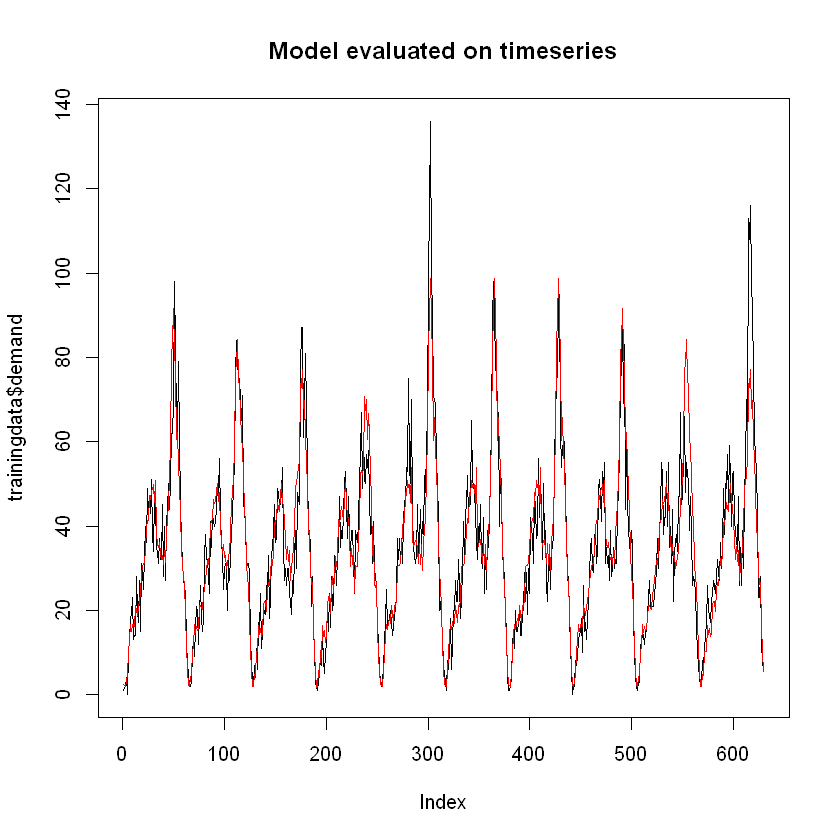

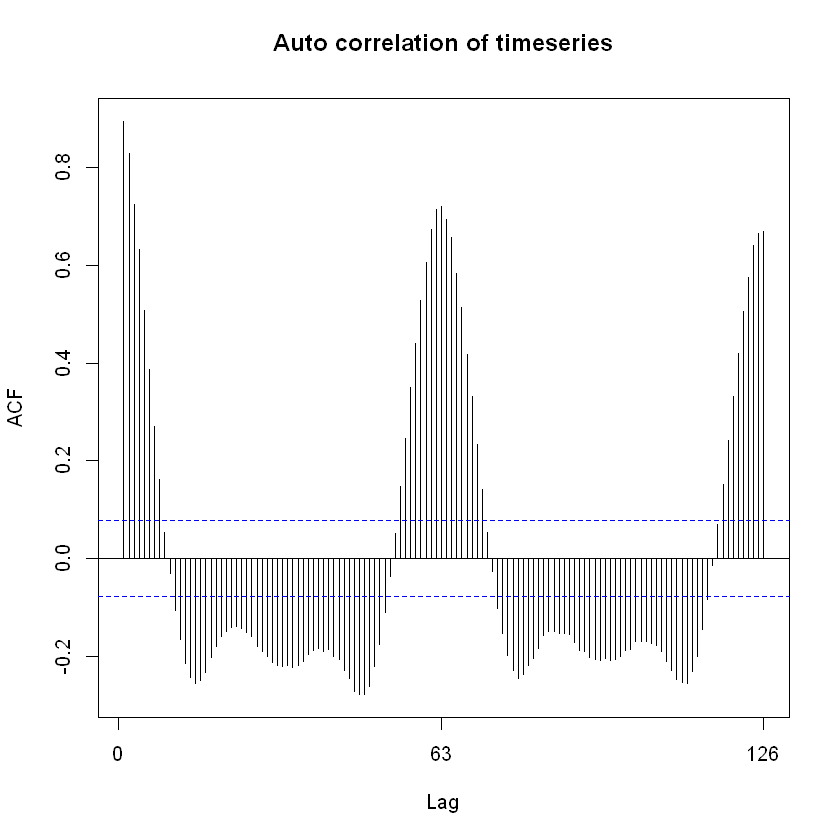

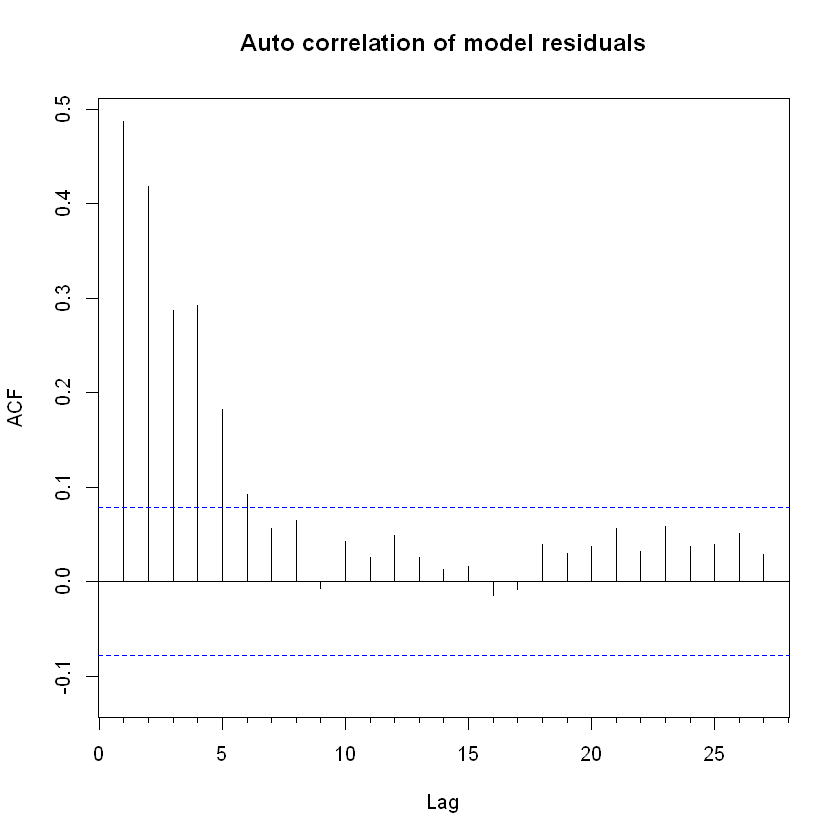

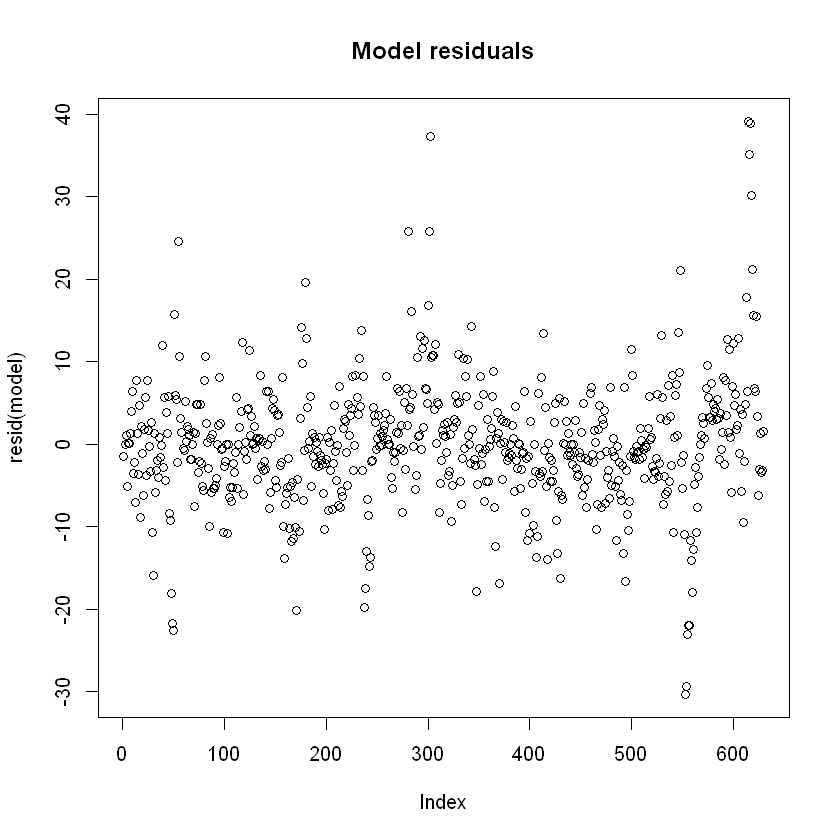

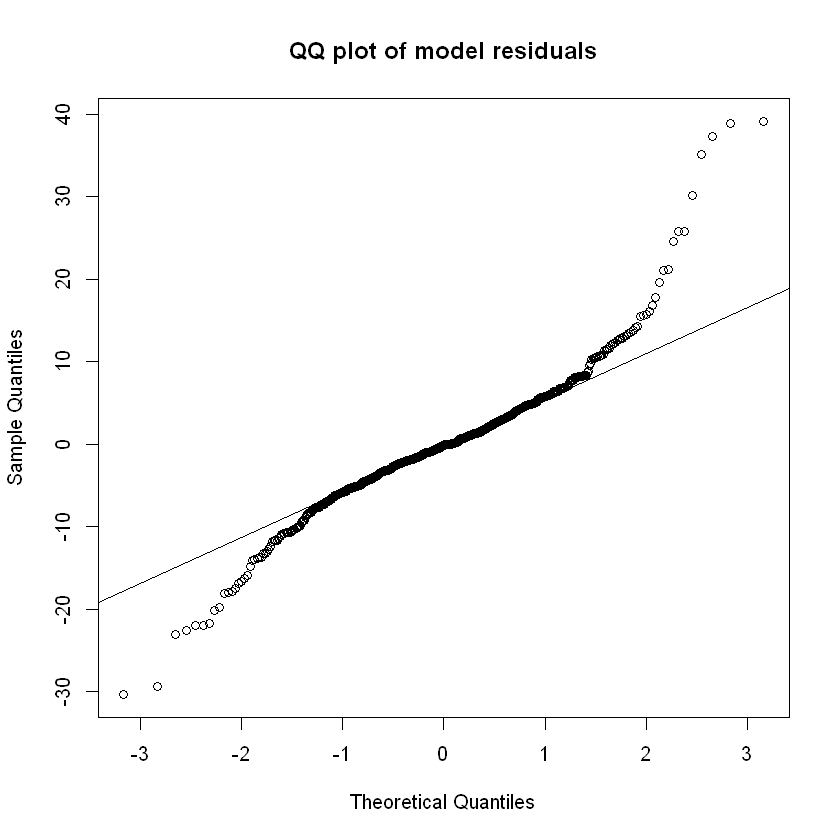

In [229]:
#coefficients(model)
coef<-coefficients(model)
plot(trainingdata$demand,main='Model evaluated on timeseries',type='l')
lines(model$fitted, lwd = 1,col='red')

#model testing
Acf(timeseries.weekday,main='Auto correlation of timeseries')
Acf(resid(model),main='Auto correlation of model residuals')
plot(resid(model),main='Model residuals')
qqnorm(resid(model),main='QQ plot of model residuals')
qqline(resid(model))

### Evaluation and predictions

In [230]:
#We create a new dataframe to make the model calculation easier below
ones<-rep(1,945)
#we remove the demand column since thats what we predict and we replace it with ones
#so they are multiplied by the intercept coefficient
final.model.data<-data.frame(ones,model.data.weekday[,-1])


head(final.model.data)
dim(final.model.data)

ones,daynumber,S1,S2,S3,S4,S5,S6,S7,S8,...,S53.day,S54.day,S55.day,S56.day,S57.day,S58.day,S59.day,S60.day,S61.day,S62.day
1,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


[1] 945 126

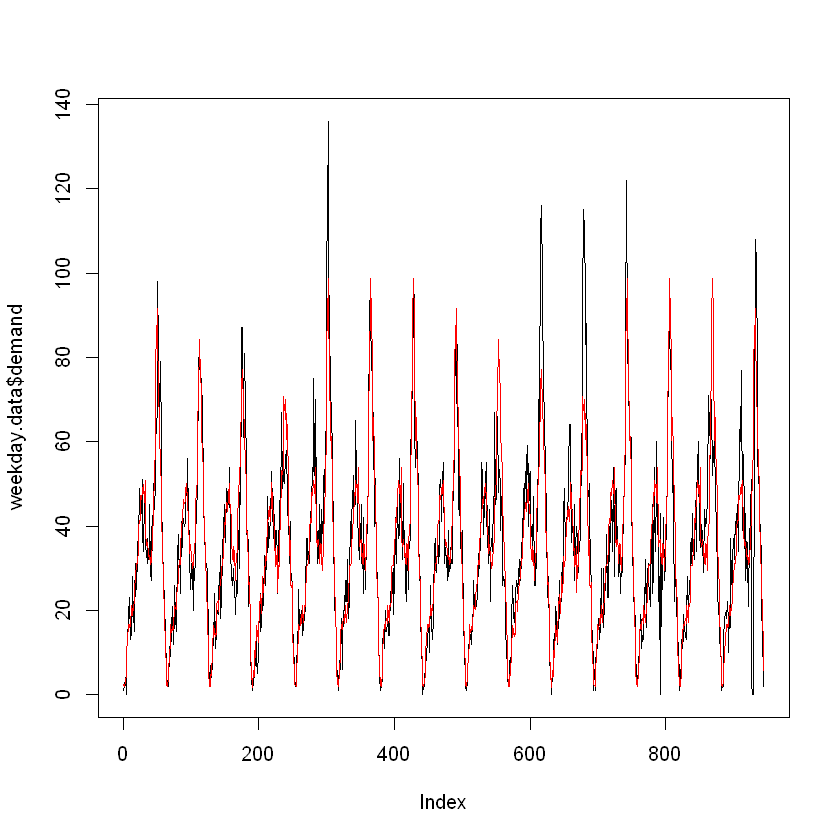

In [231]:
#coefficients(model)
coef<-coefficients(model)

mymodel = rowSums(mapply("*", as.data.frame(final.model.data),coef))

plot(weekday.data$demand,type='l')
lines(mymodel,lwd = 1,col='red')

In [239]:
actual.demand<-validation.weekday$demand
predicted.demand<-mymodel[631:945]

residuals<-actual.demand-predicted.demand

#Adjusted R-Squared
n=length(actual.demand)
k=126-1 #Subtract one to ignore intercept
SSE=sum(residuals**2)
SSyy=sum((actual.demand-mean(actual.demand))**2)
1-(SSE/SSyy)*(n-1)/(n-(k+1))

[1] 0.4817584

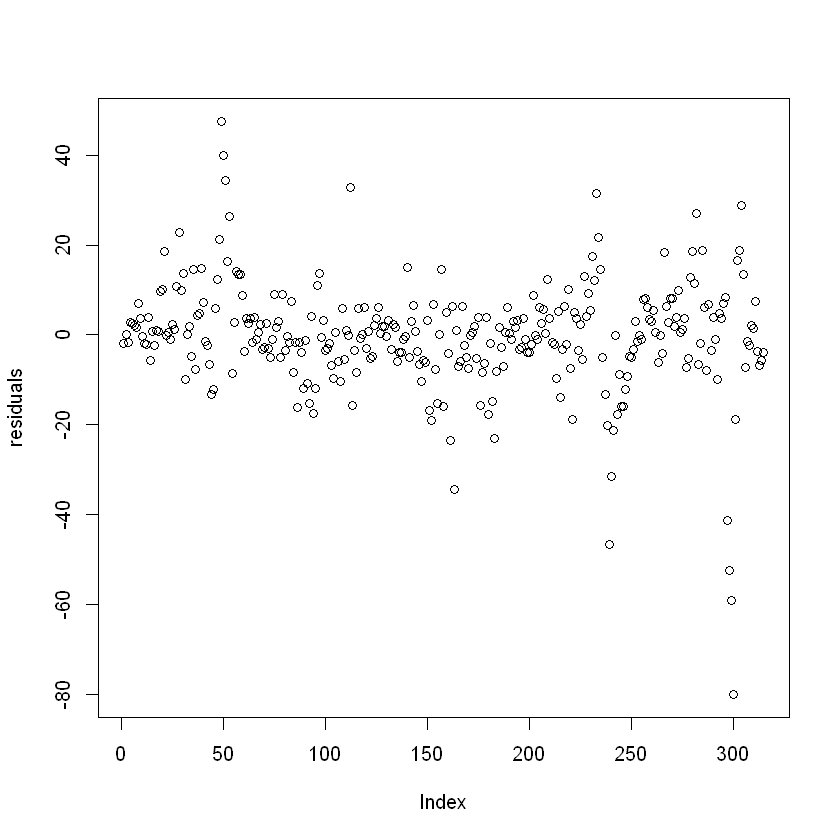

In [240]:
plot(residuals)

In [242]:
#ON TRAIN
actual.demand<-training.weekday$demand
predicted.demand<-mymodel[1:630]

residuals<-actual.demand-predicted.demand

#Adjusted R-Squared
n=length(actual.demand)
k=126-1 #Subtract one to ignore intercept

SSE=sum(residuals**2)
SSyy=sum((actual.demand-mean(actual.demand))**2)
1-(SSE/SSyy)

[1] 0.8702155

# Summary

It turns out that this model performs worse than our original one.

In [272]:
library('RSNNS')

In [280]:
# Fit MLP
mlp.fit <- mlp(model.data.weekday[-1],model.data.weekday[1])
#plot(mlp.fit)
print(mlp.fit)

Class: mlp->rsnns
Number of inputs: 125 
Number of outputs: 1 
Maximal iterations: 100 
Initialization function: Randomize_Weights 
Initialization function parameters: -0.3 0.3 
Learning function: Std_Backpropagation 
Learning function parameters: 0.2 0 
Update function:Topological_Order
Update function parameters: 0 
Patterns are shuffled internally: TRUE 
Compute error in every iteration: TRUE 
Architecture Parameters:
$size
[1] 5

All members of model:
 [1] "nInputs"               "maxit"                 "initFunc"             
 [4] "initFuncParams"        "learnFunc"             "learnFuncParams"      
 [7] "updateFunc"            "updateFuncParams"      "shufflePatterns"      
[10] "computeIterativeError" "snnsObject"            "archParams"           
[13] "IterativeFitError"     "fitted.values"         "nOutputs"             


In [283]:
mlp.frc <- forecast(mlp.fit)
plot(mlp.frc)

ERROR: Error in is.constant(y): (list) object cannot be coerced to type 'double'
